In [10]:

import argparse
import pathlib

import numpy as np
import cv2

import torch
import torchvision

import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as Image

from models.pfld import PFLDInference, AuxiliaryNet
from mtcnn.detector import detect_faces
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_path = 'checkpoint\snapshot\checkpoint\snapshot\checkpoint_epoch_280.pth.tar'

input_path = 'input\\inho.jpg'
output_path = str('result\\inho.jpg')
eye_cm = 5.8

output_path_trigger = True
image_show = False


checkpoint = torch.load(model_path, map_location=device)
pfld_backbone = PFLDInference().to(device)
pfld_backbone.load_state_dict(checkpoint['pfld_backbone'])
pfld_backbone.eval()
pfld_backbone = pfld_backbone.to(device)
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

cap = cv2.VideoCapture(str(pathlib.Path(input_path)))

if not (output_path_trigger is None):
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    size = (frame_width, frame_height)
    fps = cap.get(cv2.CAP_PROP_FPS)
    result_path = pathlib.Path(output_path)
    result = cv2.VideoWriter(str(result_path), 
                        cv2.VideoWriter_fourcc(*'MJPG'),
                        fps, size)

while True:
    ret, img = cap.read()
    if not ret: break
    height, width = img.shape[:2]
    bounding_boxes, landmarks = detect_faces(img)
    for box in bounding_boxes:
        x1, y1, x2, y2 = (box[:4] + 0.5).astype(np.int32)

        w = x2 - x1 + 1
        h = y2 - y1 + 1
        cx = x1 + w // 2
        cy = y1 + h // 2

        size = int(max([w, h]) * 1.1)
        x1 = cx - size // 2
        x2 = x1 + size
        y1 = cy - size // 2
        y2 = y1 + size
        
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)
        edx1 = max(0, -x1)
        edy1 = max(0, -y1)
        edx2 = max(0, x2 - width)
        edy2 = max(0, y2 - height)

        cropped = img[y1:y2, x1:x2]
        if (edx1 > 0 or edy1 > 0 or edx2 > 0 or edy2 > 0):
            cropped = cv2.copyMakeBorder(cropped, edy1, edy2, edx1, edx2,
                                         cv2.BORDER_CONSTANT, 0)

        input = cv2.resize(cropped, (112, 112))
        input = transform(input).unsqueeze(0).to(device)
        _, landmarks = pfld_backbone(input)
        pre_landmark = landmarks[0]
        pre_landmark = pre_landmark.cpu().detach().numpy().reshape(
            -1, 2) * [size, size] - [edx1, edy1]
        

        pre_lm_list = pre_landmark.tolist()
        if len(list(pre_landmark)) != 98:
            print('can not find face image')
            exit()
        
        new_lm_x = []
        new_lm_y = []
        
        for (x, y) in pre_landmark.astype(np.int32):
            cv2.circle(img, (x1 + x, y1 + y), 1, (0, 0, 255))
            new_lm_x.append(x1+x)
            new_lm_y.append(y1+y)
            
    
cap.release()
result.release()

lm_x = new_lm_x
lm_y = new_lm_y
eye_dist = sqrt((lm_x[96]-lm_x[97])**2 +(lm_y[96]-lm_y[97])**2)
face_width = sqrt((lm_x[0]-lm_x[32])**2 +(lm_y[0]-lm_y[32])**2)
face_width_ratio = face_width/eye_dist
face_width_cm = face_width_ratio*eye_cm
print(str(face_width_cm)+' cm')


12.863806053674637 cm


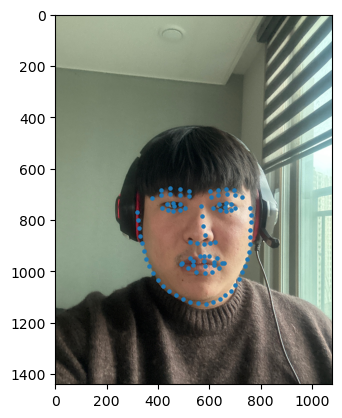

[[415, 436, 460, 486, 506, 484, 460, 437]]


In [11]:


x = [i[0]*864/100 for i in pre_lm_list]
y = [(100-i[1])*1152/100 for i in pre_lm_list]

x_test = [new_lm_x[60:68]]
y_test = [new_lm_y[68:76]]

image = Image.imread(input_path)
plt.imshow(image)

plt.scatter(new_lm_x, new_lm_y, s= 5)
plt.show()


plt.save

In [32]:
lm_x = new_lm_x
lm_y = new_lm_y

In [33]:

eye_dist = sqrt((lm_x[96]-lm_x[97])**2 +(lm_y[96]-lm_y[97])**2)
face_width = sqrt((lm_x[0]-lm_x[32])**2 +(lm_y[0]-lm_y[32])**2)

In [34]:
face_width

1134.0745125431574

In [35]:
eye_dist

483.00414076900006

In [36]:
face_width_ratio = face_width/eye_dist
face_width_cm = face_width_ratio*eye_cm

In [37]:
print(face_width_cm)

13.61816932309926
